In [17]:
import pandas as pd
import xarray as xr
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [18]:
base_url_t = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url_ppt = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
base_url2t = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base2ppt1 = '/e5.moda.fc.sfc.accumu.128_142_lsp.ll025sc.'
base2ppt2 = '/e5.moda.fc.sfc.accumu.128_143_cp.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

from datetime import timedelta
from dateutil. relativedelta import relativedelta
file_list_t=[]
file_list_lsp = []
file_list_cp = []
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y') 
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt+ pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_filet =(base_url_t+year+base_url2t + month +'_'+ month2 +base_url3)
    file_list_t.append(single_filet)
    file_lsp = (base_url_ppt+year+base2ppt1 + month +'_'+ month2 +base_url3)
    file_list_lsp.append(file_lsp)
    file_cp = (base_url_ppt+year+base2ppt2 + month +'_'+ month2 +base_url3)
    file_list_cp.append(file_cp)

In [19]:
sstk = xr.open_mfdataset(file_list_t, parallel = True).sel(latitude = slice(65,-65,4),longitude = slice(120,300,4))
lsp = xr.open_mfdataset(file_list_lsp, parallel = True).sel(latitude = slice(65,-65,4),longitude = slice(120,300,4))
cp = xr.open_mfdataset(file_list_cp, parallel = True).sel(latitude = slice(65,-65,4),longitude = slice(120,300,4))

In [20]:
dmask = xr.open_dataset('https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1979/e5.moda.an.sfc.128_172_lsm.ll025sc.1979010100_1979120100.nc')

In [21]:
sstk = sstk.SSTK.where(dmask.LSM.isel(time=0) == 0)
lsp = lsp.LSP.where(dmask.LSM.isel(time=0) == 0)
cp = cp.CP.where(dmask.LSM.isel(time=0) == 0)

In [22]:
tp = lsp+cp 
#Total precipitation

In [23]:
#Calculate anomalies / Deseasonalizing
sstkanom = sstk.groupby('time.month') - sstk.groupby('time.month').mean(dim='time')
tpanom = tp.groupby('time.month') - tp.groupby('time.month').mean(dim='time')

/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]
/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


In [24]:
#Detrending
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# -- Running mean
sst_dtrend = detrend_dim(sstkanom,'time',1)

In [40]:
#Standardize 
clim_mean = sst_dtrend.groupby('time.month').mean('time')
clim_std = sst_dtrend.groupby('time.month').std('time')
stdanom = (sst_dtrend.groupby('time.month')/clim_std).groupby('time.month')-(clim_mean/clim_std)

/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]
/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


In [42]:
stdanom = stdanom.drop('month')

In [43]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from eofs.xarray import Eof
import numpy as np

In [44]:
stdanom  = stdanom.chunk({'time':-1})

In [45]:
coslat = np.cos(np.deg2rad(stdanom.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(stdanom , weights=wgts)

/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [46]:
eof1 = solver.eofsAsCorrelation(neofs=10)
pc1 = solver.pcs(npcs=10, pcscaling=1)

/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


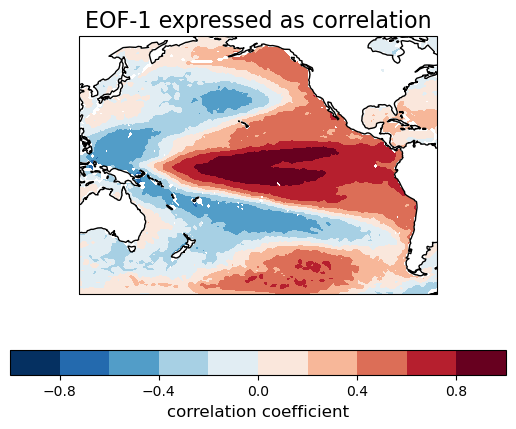

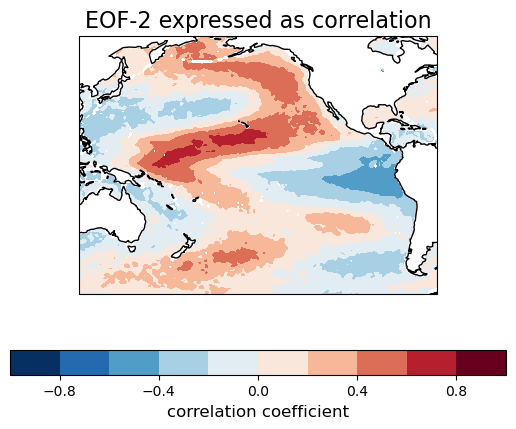

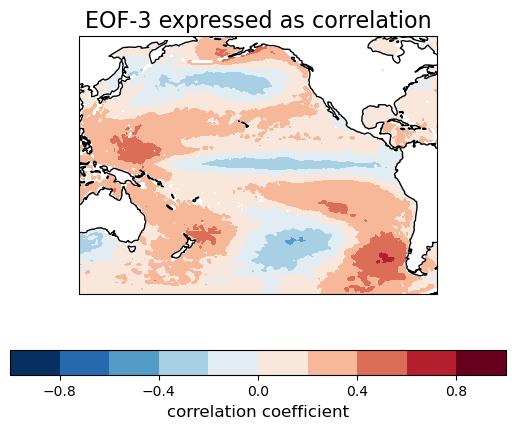

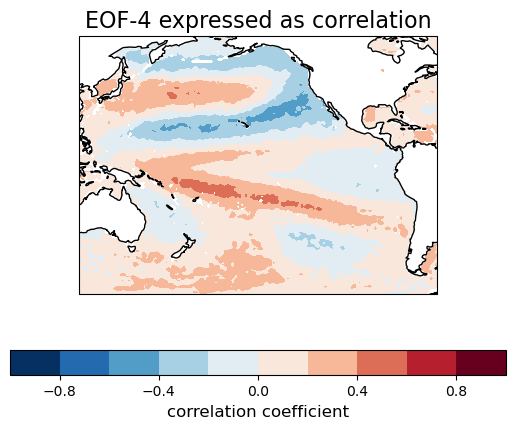

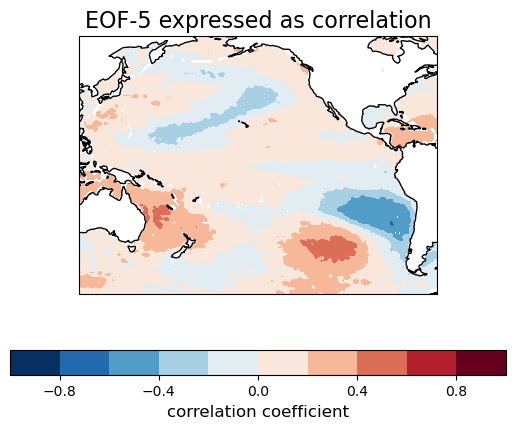

In [47]:
# Plot the first five EOFs expressed as correlation in the Pacific domain.
for i in range(len(eof1[:5])):
    clevs = np.linspace(-1, 1, 11)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
    fill = eof1[i].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                                 add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    cb = plt.colorbar(fill, orientation='horizontal')
    cb.set_label('correlation coefficient', fontsize=12)
    ax.set_title('EOF-'+str(i+1)+ ' expressed as correlation', fontsize=16)
    plt.show()

In [48]:
varfrac = solver.varianceFraction()

(4.817774285273591e-34, 0.1933732188594426)

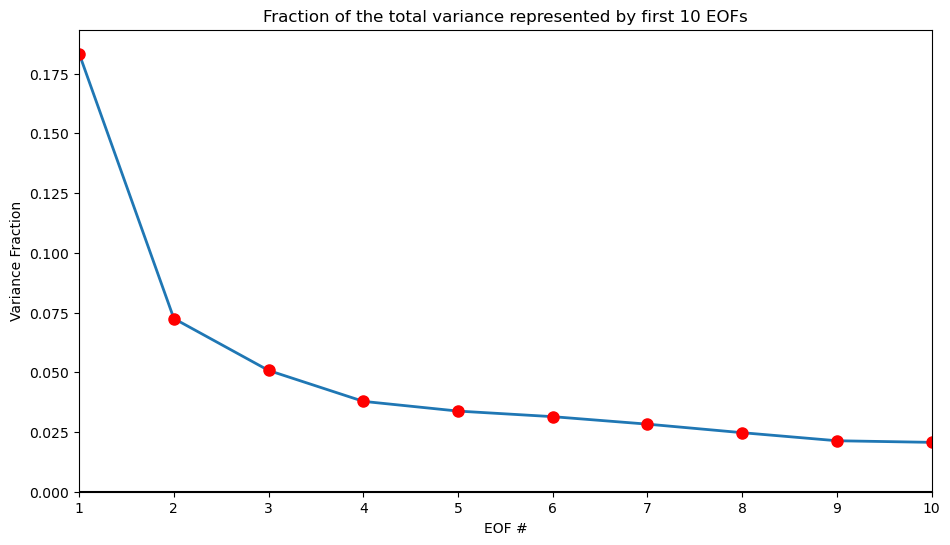

In [49]:
# Plot the fraction of variance explained by first 10 EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[:10], linewidth=2)
plt.plot(eof_num, varfrac[:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Fraction of the total variance represented by first 10 EOFs')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

In [50]:
#Reconstruct the SST field using the first 5 EOFs
reconstruction = solver.reconstructedField(5)
reconstruction

<xarray.DataArray 'true_divide-ce538d2919835e84d6bd7bb321f47b17' (time: 516,
                                                                  latitude: 131,
                                                                  longitude: 181)>
dask.array<true_divide, shape=(516, 131, 181), dtype=float64, chunksize=(516, 131, 181), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
Attributes:
    long_name:  None_reconstructed_with_5_EOFs

In [51]:
#plot a map of the Pearson's correlation coefficient (xarray.corr) of the reconstructed monthly time series and the "observed" SST time series
corr = xr.corr(reconstruction,sst_dtrend,dim=('time'))

/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


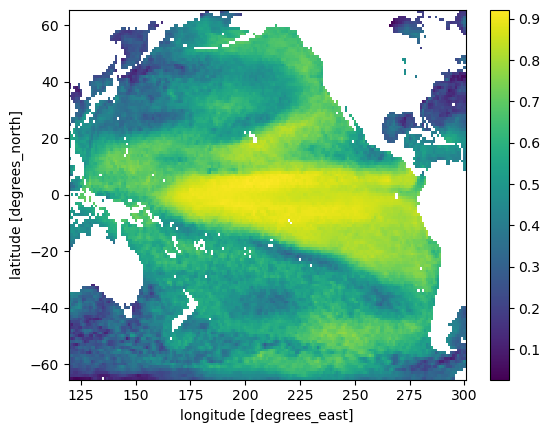

In [52]:
corr.plot()

In [53]:
#Unmasked precipitation over land 
lsp_unmask = xr.open_mfdataset(file_list_lsp, parallel = True).sel(latitude = slice(65,-65,4),longitude = slice(120,300,4))
cp_unmask = xr.open_mfdataset(file_list_cp, parallel = True).sel(latitude = slice(65,-65,4),longitude = slice(120,300,4))

In [54]:
tp_unmask = lsp_unmask.LSP + cp_unmask.CP
tpanom_unmask =  tp_unmask.groupby('time.month') - tp_unmask.groupby('time.month').mean(dim='time')

/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


In [58]:
#Detrend ppt
tp_dtrend = detrend_dim(tpanom_unmask,'time',1)

In [59]:
#Standardize ppt anomalies
ppt_mean = tp_dtrend.groupby('time.month').mean('time')
ppt_std = tp_dtrend.groupby('time.month').std('time')
pptstdanom = (tp_dtrend.groupby('time.month')/ppt_std).groupby('time.month')-(ppt_mean/ppt_std)

/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]
/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


In [60]:
corpptstd = xr.corr(eof1[0],pptstdanom ,dim='time')

In [63]:
corpptstd

<xarray.DataArray (latitude: 131, longitude: 181)>
dask.array<truediv, shape=(131, 181), dtype=float64, chunksize=(131, 181), chunktype=numpy.ndarray>
Coordinates:
    mode       int64 0
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0

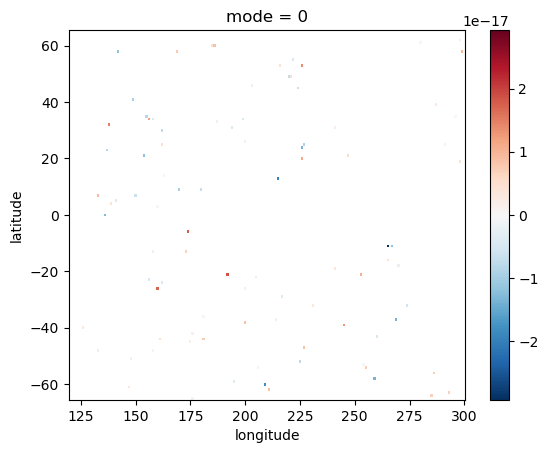

In [64]:
#Map of correlation between first eof and unmasked precipitation anomalies
corpptstd.plot()